In [1]:
from tqdm import tqdm

import os
from dotenv import load_dotenv
from datasets import load_dataset
load_dotenv()
tqdm.pandas()
import pandas as pd
import ast
import re
import torch
import torch.nn.functional as F
from dataset_utils import *
import sys
sys.path.append("..")
from config import *

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Loading Dataset

In [2]:
dataset = load_dataset("go_emotions", "simplified")
dataset.set_format(type="pandas")
df_train = dataset["train"][:]
df_train = df_train.drop(columns=["id"])

int2label = lambda x: dataset["train"].features["labels"].feature.int2str(x)
df_train["labels_text"] = df_train["labels"].apply(int2label)

,text,labels,labels_text
0,My favourite food is anything I didn't have to...,[27],[neutral]
1,"Now if he does off himself, everyone will thin...",[27],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[2],[anger]
3,To make her feel threatened,[14],[fear]
4,Dirty Southern Wankers,[3],[annoyance]


In [10]:
# samples = df_train[df_train["ds_emotions"].apply(lambda x: "neutral" in x)]
samples = df_train.sample(50, random_state=RANDOM_SEED)

# LLM Labeling

In [11]:
SYSTEM_MESSAGE = "You're an AI expert trained to analyze and categorize emotions present in text. Your goal is to analyze each piece of text according to instructions"

PROMPT_TEMPLATE = f"""
Given: {{comment}}
Emotion list: {EMOTIONS}
Perform an emotional analysis of the comment to by following these steps:

Literal analysis: Identify emotions directly expressed through obvious emotional words/phrases.
Contextual analysis: Consider the full context and implications to detect any additional underlying emotions.
Tonal analysis: Examine tone, subtext, and nuanced emotional cues beyond the literal language.

You may only pick one, two or three classes.

For each level of analysis, provide your findings.
Then, summarize by listing the emotion class(es) that apply in <answer> (classes) </answer>. Use "neutral" ONLY if no emotions from the list are detected.
"""


final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_MESSAGE),
        # few_shot_prompt,
        ("human", PROMPT_TEMPLATE),
    ]
)

In [12]:
providers_api_base = {
    "ollama": "http://localhost:11434/v1",
    # models in https://fireworks.ai/models
    "fireworks": "https://api.fireworks.ai/inference/v1",
    # models in https://console.groq.com/docs/models
    "groq": "https://api.groq.com/openai/v1",
    # models in https://platform.openai.com/docs/models
    "openai": "https://api.openai.com/v1",
}

In [13]:
model_name = "accounts/fireworks/models/llama-v3-70b-instruct"
provider = "fireworks"
TEMPERATURE = 0.6

# Define models
chat = ChatOpenAI(
    temperature=TEMPERATURE,
    model_name=model_name,
    openai_api_base=providers_api_base[provider],
    openai_api_key=os.environ[provider],
)

chain = final_prompt | chat

In [14]:
samples["predictions"] = None
input_tokens = 0
output_tokens = 0
# for index in range(len(samples)):
for index in tqdm(samples.index):
    comment = samples.loc[index]["text"]
    label = samples.loc[index]["labels_text"]
    response = chain.invoke({"comment": comment})
    content = response.content
    input_tokens += response.response_metadata["token_usage"]["prompt_tokens"]
    output_tokens += response.response_metadata["token_usage"]["completion_tokens"]
    extracted_emotions = extract_emotions(content)
    samples.at[index, "predictions"] = extracted_emotions

input_tokens = input_tokens / len(samples)
output_tokens = output_tokens / len(samples)

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


# Evaluation

Results for llama-v3-70b-instruct:
Average BCE Loss: 4.4800
Average F1 Score: 0.2176
Average Precision: 0.2136
Average Recall: 0.3528
Average Accuracy: 0.0186


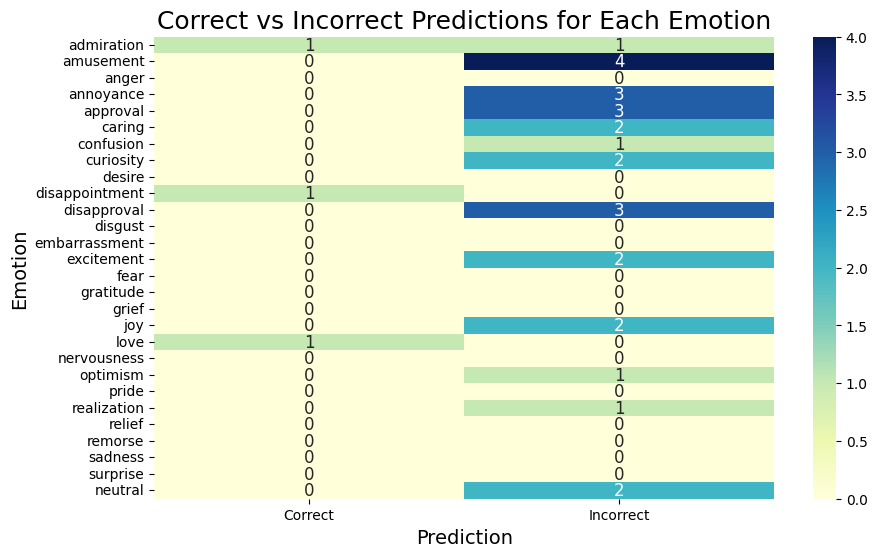

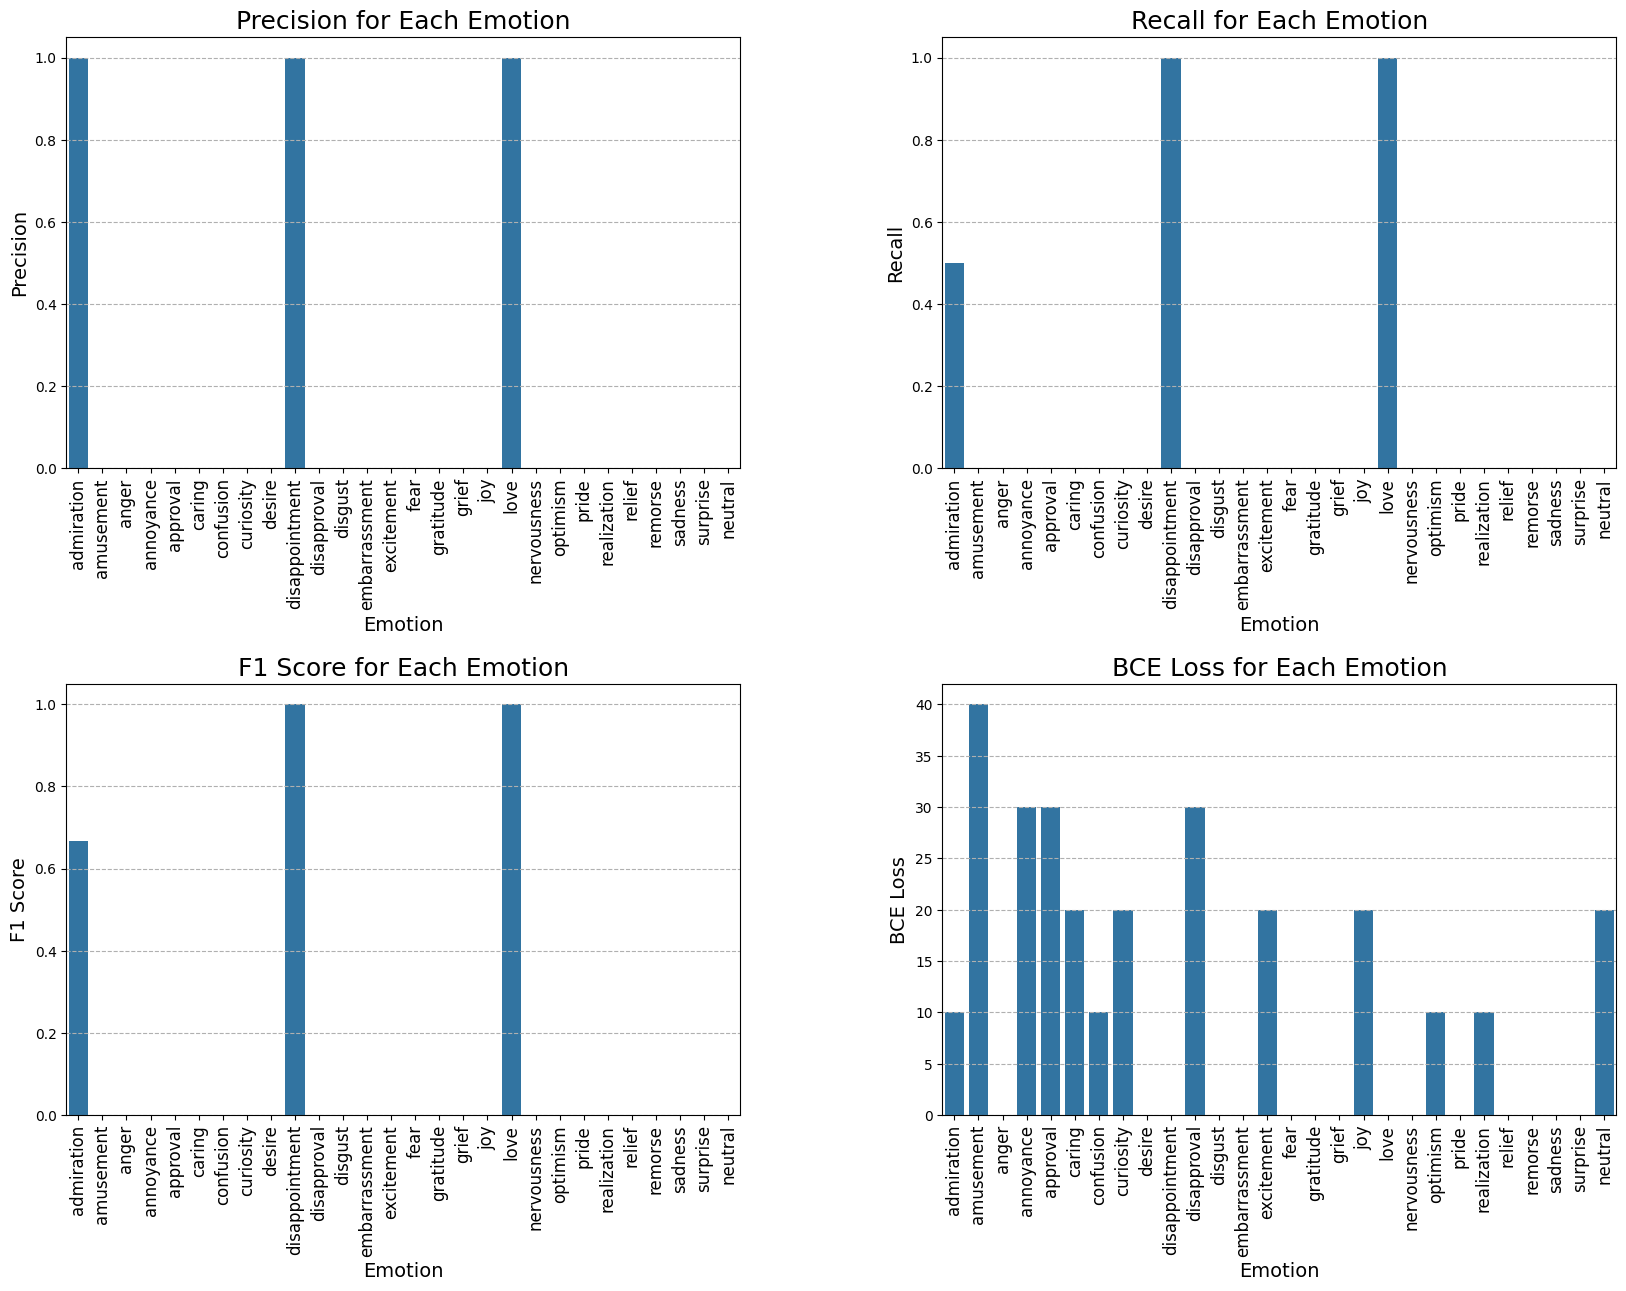

In [15]:
predicted_labels = samples["predictions"]

kwargs = {
    # Default Kwargs
    "provider": provider,
    "temperature": TEMPERATURE,
    "avg_input_tokens": input_tokens,
    "avg_output_tokens": output_tokens,
    # Additional Kwargs
    "ensemble": 1,
}


process_save_results(
    model_name.split("/")[-1],
    SYSTEM_MESSAGE,
    PROMPT_TEMPLATE,
    predicted_labels,
    samples["labels_text"],
    EMOTIONS,
    verbose=True,
    trial_num =1,
    **kwargs,
)